In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', test_size = 0.2, random_state = 0):

        self.data = data
        self.label_col = label_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model
        self.skl_model.fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))

In [3]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [4]:
from sklearn.neural_network import MLPRegressor
data_arr = []
take_sample = False
for i in range(len(truths) - 2):
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    
    if take_sample:
        data = data.sample(frac=0.5, replace=True, random_state=1)
    
    data = data.iloc[1000: , :]
    data_arr.append(data)
data = pd.concat(data_arr)

ml = RppgMl(data)
print(f'Training on {len(ml.X_train)} samples')

mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)
rf = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=0, criterion="mse")

ml.train_skl(rf)
ml.eval_skl()

Training on 70412 samples


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.0027047246373588345

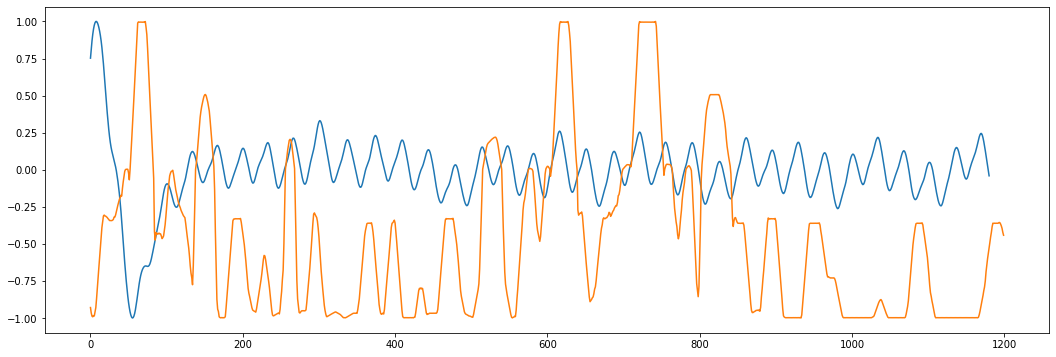

In [5]:
test_subject = 5
test_data = truths[test_subject - 1].prepare_data_for_ml()
test_X = test_data.drop(columns = ['bvp']).to_numpy()
test_y = test_data.bvp.to_numpy()


pred = ml.predict_skl(test_X)
pred = n_moving_avg(pred, 10)
pred = resample(pred, len(test_y))
# pred = normalize_amplitude_to_1(pred)

beg = 400
end = 1600

signal = pred[beg: end]
gt = n_moving_avg(test_y[beg: end], 20)

signal = normalize_signal(signal)
signal = normalize_amplitude_to_1(signal)
gt = normalize_signal(gt)
gt = normalize_amplitude_to_1(gt)

plt.plot(gt)
plt.plot(signal)

# interval = 400
# for beg in range(0, len(test_y), interval):
#     end = beg + interval
#     plt.plot(test_y[beg: end])
#     plt.plot(pred[beg: end])
#     plt.show()

### Try to apply pipeline methods now

In [6]:
# from wavelet import apply_wavelet
# waveletified_signal = apply_wavelet(signal, wave = 'db2', level = 2)
# plt.plot(gt)
# plt.plot(waveletified_signal)

In [7]:
from scipy.signal import find_peaks, peak_prominences
def get_peaks(signal: np.ndarray, fr: int, max_freq: float, peak_height: float,
    slice_filter_thresh: int, perc1: float, perc2: float, prominence: float or None = None,
    with_min_dist: bool = True, with_additional_filtering: bool = True):
    """
    The current standard method for peak detection. Includes the option to use the _filter_peaks
    method for even more aggressive filtering.
    """
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    signal = signal[first_index: ]
    
    # apply a min distance if its given, otherwise just make it 1
    if with_min_dist:
        min_dist = fr // max_freq
    else:
        min_dist = 1
    
    # if prominence is None, make it 0
    if prominence is None:
        prominence = 0
    
    peaks, _ = find_peaks(signal, height = peak_height, prominence = prominence, distance = min_dist)

    if with_additional_filtering:
        peaks = _filter_peaks(signal, peaks, fr, slice_filter_thresh, perc1, perc2)
    
    prominences = {p + first_index: prom for p, prom in zip(peaks, peak_prominences(signal, peaks)[0])}
    return [p + first_index for p in peaks], prominences


def _filter_peaks(signal: np.ndarray, peaks: np.ndarray, fr: int,
    slice_filter_thresh: int, perc1: float, perc2: float):
    """
    Filter peaks with the intent of trying to peaks that are "definitely" noise.
    """

    # first, remove peaks that aren't sufficienrtly above the perc2 percentile. I intentionally
    # am comparing the peaks to the entire array, and not just the set of peaks, because I'm not
    # making the assumption that a certain percentage of peaks will inherently be noisy. However,
    # I am making the assumption that if the peak is insufficiently clear of a certain baseline of
    # the entire signal, then it must be noise.
    peaks = np.array([p for p in peaks if signal[p] >= np.percentile(signal, perc2)])   
    
    # Peak Walk: remove peaks that are close together, that aren't sufficiently large relative to the
    # entire signal. This percentile (perc1) is more stringent than the one used in the first step.
    for i in range(0, len(signal) - fr, fr):
        
        j = i + fr
        slce = peaks[(peaks >= i) & (peaks < j)]
        
        if len(slce) > slice_filter_thresh:
            to_remove = [i for i in range(len(slce)) if signal[slce[i]] < np.percentile(signal[slce], perc1)]
            peaks = peaks[~np.isin(peaks, [slce[i] for i in to_remove])]
            # removed += len(to_remove)
    
    return peaks

Number of true peaks: 32
Number of predicted peaks: 19


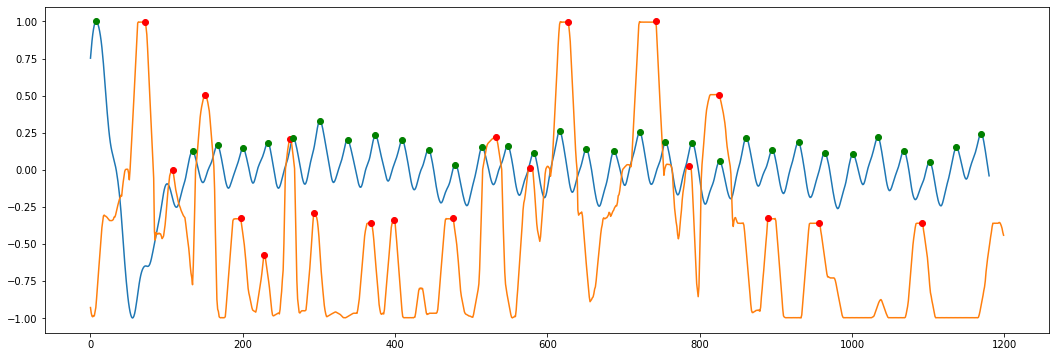

In [8]:
peaks, _ = get_peaks(
    signal,
    64,
    3.0,
    -1,
    None,
    None,
    None,
    with_min_dist = True,
    with_additional_filtering = False,
    prominence = 0.3
)
true_peaks, _ = get_peaks(
    gt,
    64,
    3.0,
    -1,
    None,
    None,
    None,
    with_min_dist = True,
    with_additional_filtering = False,
    prominence = 0.2
)

plt.plot(gt)
plt.plot(signal)
plt.plot(peaks, signal[peaks], 'ro')
plt.plot(true_peaks, gt[true_peaks], 'go')

print(f'Number of true peaks: {len(true_peaks)}')
print(f'Number of predicted peaks: {len(peaks)}')


In [9]:
from signal_pross import get_ibis, get_hr

true_ibis = get_ibis(true_peaks, 64)
true_hr = get_hr(true_ibis)
pred_ibis = get_ibis(peaks, 64)
pred_hr = get_hr(pred_ibis)

print('True HR:', true_hr)
print('Pred HR:', pred_hr)


True HR: 102.44406196213426
Pred HR: 67.76470588235294


In [10]:
sam = sorted(pred_ibis)[1: -1]
60/np.mean(sam)

71.85964912280701